In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import rc
import scipy.io as sio
import os 
import itertools
import re
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Polygon
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA
%matplotlib inline
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'weight' : 'light',
        'size'   : 20}

rc('font', **font)

In [2]:
DEBUG = False

In [3]:
def load_data(file_path, file_name, user_id, g_phase_id, phase_id, movement_id):
    mat = sio.loadmat(file_path)
    mat_data = mat[file_name]['daq'][0, 0]
    t = pd.DataFrame(mat_data['t'][0,0], columns = ["timeStamp"])
    data = pd.DataFrame(mat_data['DAQ_DATA'][0, 0], columns = [
        'channel_1',
        'channel_2',
        'channel_3',
        'channel_4',
        'channel_5',
        'channel_6',
        'channel_7',
        'channel_8'
      ])
    #res = pd.concat([t, data], axis = 1, ignore_index = False, sort = False).set_index('TimeStamp')
    res = pd.concat([t, data], axis = 1, ignore_index = False, sort = False)
    res['userID'] = user_id
    res['gamePhase'] = g_phase_id
    res['testPhase'] = phase_id
    res['movementID'] = movement_id
    return res

In [4]:
def generate_df():
    df = pd.DataFrame() # Main DataFrame
    rootdir = os.path.join(os.getcwd() + "/Data_Sets/")
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file.endswith(".mat"):
                file_path = os.path.join(subdir, file)
                file_name = file.replace(".mat", "")
                try: 
                    list_subdir = subdir.replace(rootdir,"").split("/")
                    user_id = [s for s in list_subdir if "user" in s][0].replace("user_","")
                    g_phase_id = [s for s in list_subdir if "game" in s][0] # Trainig Phase ID
                    list_fileName = ["".join(x) for _, x in itertools.groupby(file.split("_")[1].replace("Phase", ""), key=str.isdigit)]
                    phase_id = list_fileName[0].replace("Phase", "") 
                    movement_id = re.sub(r"(\w)([A-Z])", r"\1 \2", list_fileName[1])
                except:
                    print("Error: Please check the Directory's hierarchy -> Corrupt")
                df = df.append(load_data(file_path, file_name, user_id, g_phase_id, phase_id, movement_id)) 
    return df

In [5]:
df = generate_df()
df.head()

timeStamp  channel_1  channel_2  channel_3  channel_4  channel_5  \
0      0.000  -2.822843  -0.242390  -0.103075   0.883879  -0.342031   
1      0.001  -0.983520  -0.995575  -0.399863   0.578088  -0.412528   
2      0.002   1.082399  -1.858320  -0.624323  -0.085527  -0.156634   
3      0.003   2.019455  -2.448234  -0.753262  -0.932250   0.016403   
4      0.004   1.484779  -1.670634  -0.353170  -2.197986   0.046616   

   channel_6  channel_7  channel_8                  userID gamePhase  \
0   0.135119  -5.000000  -5.000000  20181018T164607_Danyan   Pregame   
1   0.279622  -5.000000  -5.000000  20181018T164607_Danyan   Pregame   
2   0.381552  -5.000000  -5.000000  20181018T164607_Danyan   Pregame   
3   0.526360  -5.000000  -1.978256  20181018T164607_Danyan   Pregame   
4   0.544366  -3.735332   3.829938  20181018T164607_Danyan   Pregame   

  testPhase movementID  
0         1  Hand Open  
1         1  Hand Open  
2         1  Hand Open  
3         1  Hand Open  
4         1  Hand Open

In [107]:
def phase1_pca_per_user(user_id):
    user_data = df[(df.userID == user_id) & (df.testPhase == '1') & (df.gamePhase == 'Pregame')]
    data_pre = user_data.copy()
    data_pre.drop(labels=['userID', 'gamePhase', 'testPhase', 'movementID', 'timeStamp'], axis=1, inplace=True)
    y = user_data['movementID']
    
    # Scale data
    sc = StandardScaler()
    data_scaled = sc.fit_transform(data_pre)  
    pca = PCA()  
    data_post = pca.fit_transform(data_scaled)
    explained_variance = pca.explained_variance_ratio_
    return (pca, data_post, explained_variance,y)

In [108]:
def plot_pca_scree(explained_variance, user_id, pdf):
    plt.figure(figsize=(10, 6.5))
    plt.title('PCA Variance Ratio for user ' + user_id)
    plt.plot([1,2,3,4,5,6,7,8],np.cumsum(explained_variance), label='cumulative')
    plt.plot([1,2,3,4,5,6,7,8],explained_variance, label='individual')
    plt.xlabel('number of components')
    plt.ylabel('explained variance')
    plt.legend()
    pdf.savefig()

In [122]:
def plot_pca_biplot(score,coeff,pdf,y,user_id,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    movement_to_color = {
      'No Motion': 'Blue',
      'Hand Open': 'Green',
      'Hand Closed': 'Red',
      'Wrist Pronation': 'Orange',
      'Wrist Supination': 'Purple',
      'Wrist Flexion': 'Pink',
      'Wrist Extension': 'Yellow'
    }
    color_y = []
    for movementID in y:
        color_y.append(movement_to_color[movementID])
    plt.figure(figsize=(10, 6.5))
    plt.title('Biplot for user ' + user_id)
    #plt.scatter(xs * scalex,ys * scaley, c = color_y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Channel"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    pdf.savefig()

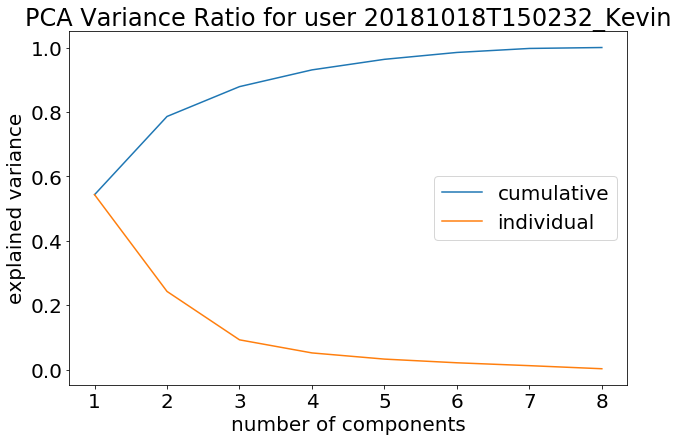

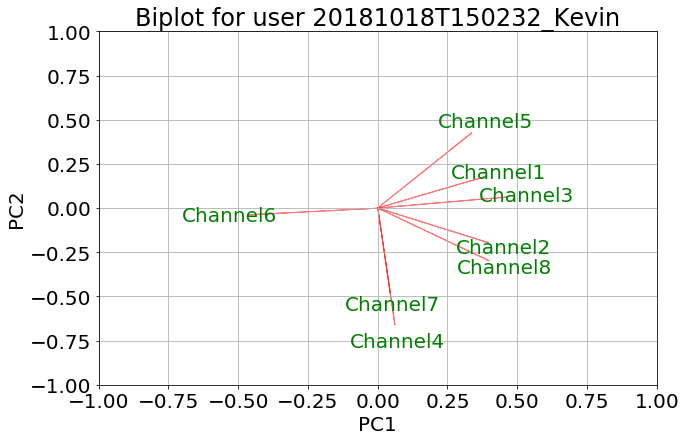

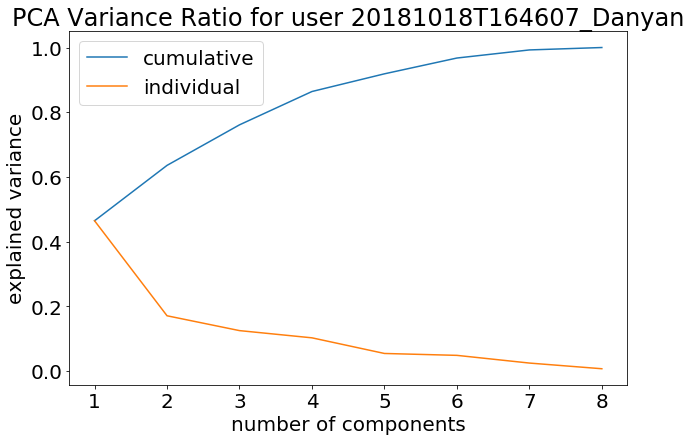

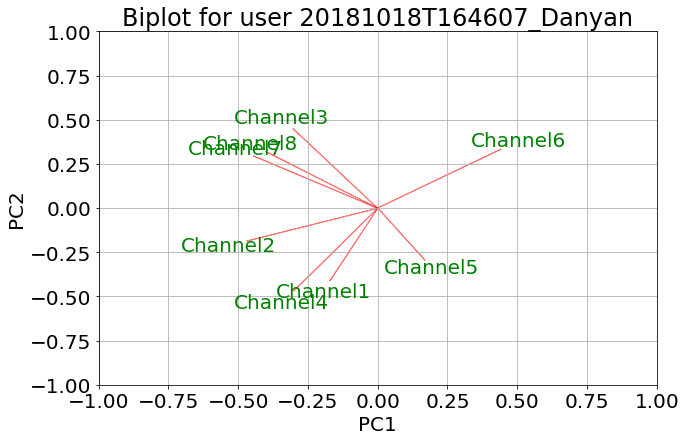

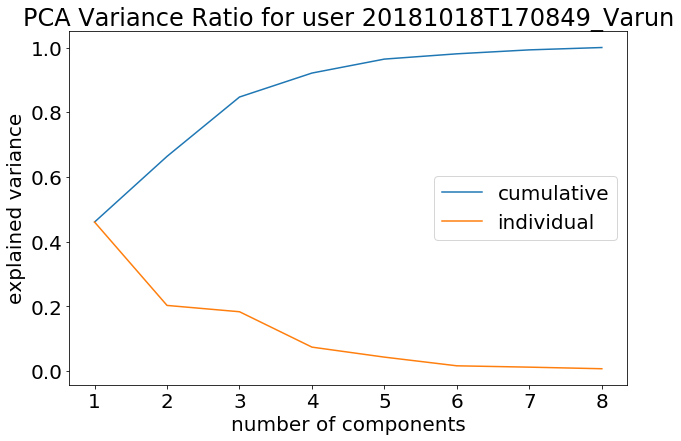

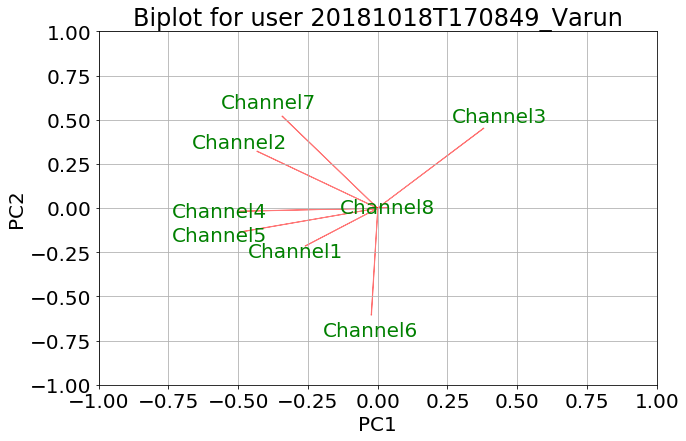

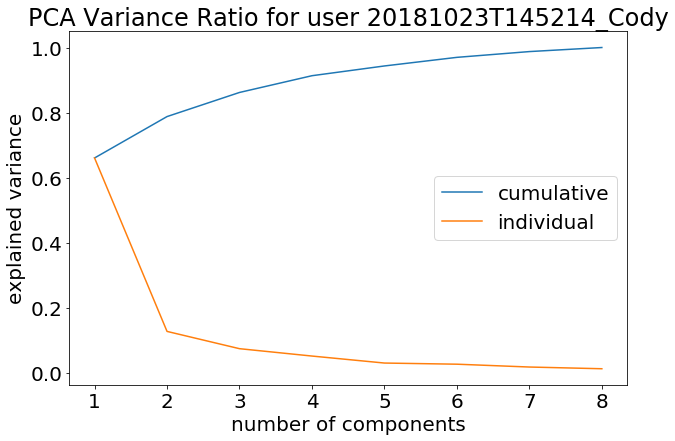

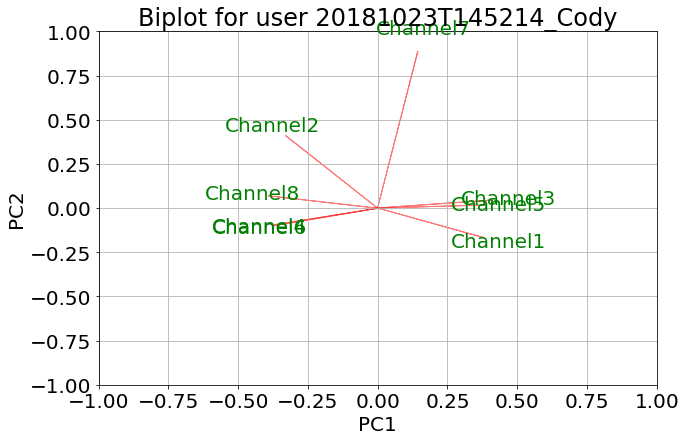

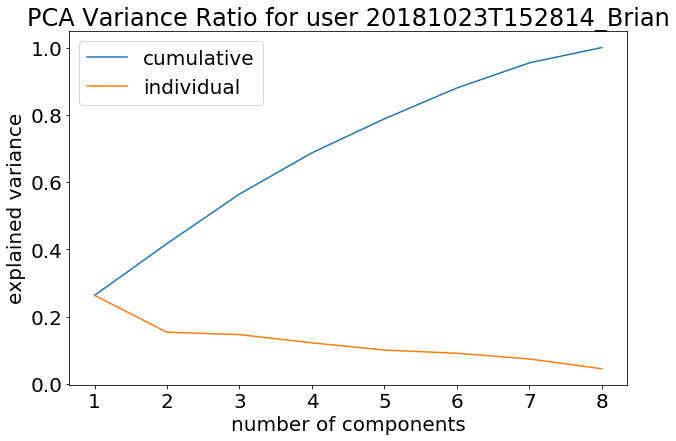

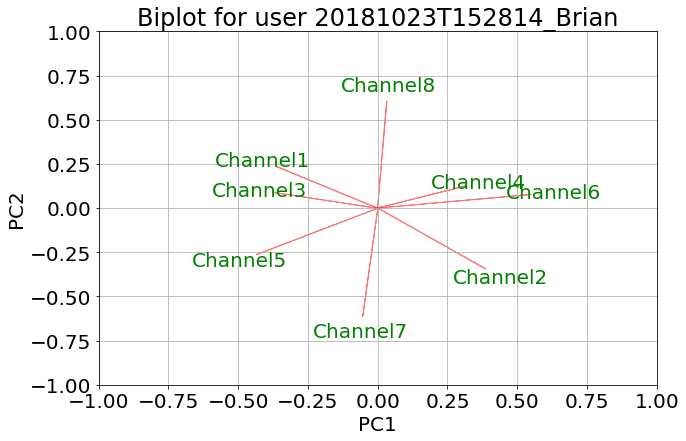

In [123]:
def phase1_pca_all_users_report():
    user_ids = np.unique(df.userID)
    pdf = PdfPages("Dataset_plots/Phase1_pca_reports.pdf")
    for user_id in user_ids:
        pca,data_post,explained_variance,y = phase1_pca_per_user(user_id)
        plot_pca_scree(explained_variance, user_id, pdf)
        plot_pca_biplot(data_post[:,0:2],np.transpose(pca.components_[0:2, :]),pdf,y,user_id)
    pdf.close()

phase1_pca_all_users_report()